# Dataset Overview
Saya menggunakan dataset dari kaggle berikut ini https://www.kaggle.com/omkargurav/face-mask-dataset

## Konten
Dataset berisi 7553 gambar (RGB) yang terdiri dari 3725 `with_mask` dan 3828 `without_mask`.

In [ ]:
import os
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
keras = tf.keras

In [ ]:
os.chdir('drive/My Drive/PythonProject/Face Mask Detection')

## Loading Data

In [ ]:
# Inisialiasi data generator beserta dengan menerapkan image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Karena gambar kita memilki ukuran yang berbeda beda maka kita resize
setiap gambar menjadi 150x150 dengan parameter target_size

In [ ]:
# Flow from directory untuk memuat gambar
train_generator = train_datagen.flow_from_directory(
    'dataset/train/',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 6043 images belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory(
    'dataset/valid/',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 1510 images belonging to 2 classes.


## Loading Dataset

In [113]:
def loading_data():
    dirname = 'dataset/'
    dirtype = ['train/','valid/']
    dirclass = ['with_mask/','without_mask/']
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for typ in dirtype:
        for cls in dirclass:
            for i in os.listdir(dirname+typ+cls):
                if typ == 'train/':
                    x_train.append(dirname+'train/'+cls+i)
                    y_train.append(cls[:-1])
                else:
                    x_test.append(dirname+'valid/'+cls+i)
                    y_test.append(cls[:-1])
    return np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)

In [114]:
x_train,y_train,x_test,y_test = loading_data()

In [115]:
x_train,x_test

(array(['dataset/train/with_mask/with_mask_3267.jpg',
        'dataset/train/with_mask/with_mask_3268.jpg',
        'dataset/train/with_mask/with_mask_3269.jpg', ...,
        'dataset/train/without_mask/without_mask_1269.jpg',
        'dataset/train/without_mask/without_mask_127.jpg',
        'dataset/train/without_mask/without_mask_1270.jpg'], dtype='<U48'),
 array(['dataset/valid/with_mask/with_mask_585.jpg',
        'dataset/valid/with_mask/with_mask_586.jpg',
        'dataset/valid/with_mask/with_mask_587.jpg', ...,
        'dataset/valid/without_mask/without_mask_442.jpg',
        'dataset/valid/without_mask/without_mask_443.jpg',
        'dataset/valid/without_mask/without_mask_444.jpg'], dtype='<U48'))

In [117]:
y_train,y_test

(array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
        'without_mask', 'without_mask'], dtype='<U12'),
 array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
        'without_mask', 'without_mask'], dtype='<U12'))

## Data Preprocessing

In [118]:
unique_label = np.unique(y_test)

In [119]:
unique_label

array(['with_mask', 'without_mask'], dtype='<U12')

In [120]:
def process_label(label):
    label = [i == unique_label for i in label]
    label = np.array(label).astype(int)
    return label

In [121]:
def processImage(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,size=[224,224])
    return image

In [122]:
y_test = process_label(y_test)
y_train = process_label(y_train)

## Batch Data

In [123]:
def pairData(image,label):
    return processImage(image),label

In [124]:
def batchData(image,label=None,for_valid=False,for_test=False):
    if for_test:
        data = tf.data.Dataset.from_tensor_slices((image))
        batch = data.map(processImage).batch(32)
        return batch
    elif for_valid:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(image),tf.constant(label)))
        batch = data.map(pairData).batch(32)
        return batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(image),tf.constant(label)))
        data = data.shuffle(buffer_size=len(image))
        batch = data.map(pairData).batch(32)
        return batch

In [125]:
train_data = batchData(x_train,y_train)
valid_data = batchData(x_test,y_test,for_valid=True)

In [126]:
train_data,valid_data

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.int64)>)

# Visualisasi Data

In [ ]:
def visualizeNextBatch(image,label):
    plt.figure(figsize=(20,10))
    for i in range(32):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(image[i])
        plt.title(unique_label[label[i].argmax()])
        plt.axis('off')

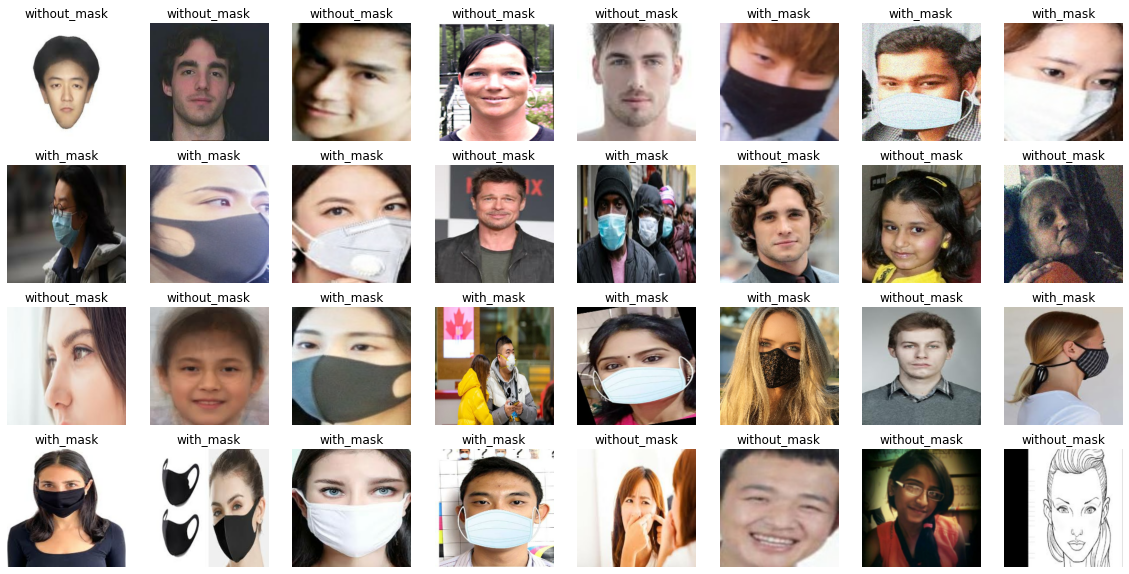

In [ ]:
train_image,train_label = next(train_data.as_numpy_iterator())
visualizeNextBatch(train_image,train_label)

# Membangun Neural Network

In [127]:
model = keras.Sequential([
    # Input Layer
    keras.layers.Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    
    # Hidden Layer
    keras.layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(input_shape=(224,224,3),filters=128,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128),
    keras.layers.Activation('relu'),
    
    # Output Layer
    keras.layers.Dense(2),
    keras.layers.Activation('softmax')
])

In [128]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 86528)            

In [129]:
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['acc'])

## Early Stopping

In [130]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

## Training NN Model

In [131]:
history = model.fit(train_data,validation_data = valid_data,validation_freq=1,epochs = 50,callbacks = [early_stopping],verbose = 1,)

Epoch 1/50
189/189 [==============================] - 24s 127ms/step - loss: 0.3455 - acc: 0.8461 - val_loss: 0.2730 - val_acc: 0.8748
Epoch 2/50
189/189 [==============================] - 23s 124ms/step - loss: 0.2099 - acc: 0.9163 - val_loss: 0.2245 - val_acc: 0.9013
Epoch 3/50
189/189 [==============================] - 23s 123ms/step - loss: 0.1524 - acc: 0.9411 - val_loss: 0.2225 - val_acc: 0.9258
Epoch 4/50
189/189 [==============================] - 23s 123ms/step - loss: 0.1078 - acc: 0.9619 - val_loss: 0.2420 - val_acc: 0.9060
Epoch 5/50
189/189 [==============================] - 23s 123ms/step - loss: 0.0757 - acc: 0.9715 - val_loss: 0.2579 - val_acc: 0.9126
Epoch 6/50
189/189 [==============================] - 23s 123ms/step - loss: 0.0521 - acc: 0.9820 - val_loss: 0.3512 - val_acc: 0.8927


In [132]:
model.save('output/face_mask_ai.h5')

## Plot Proses Training

In [172]:
def plot_history():
    plt.plot(history.history['acc'],label='acc')
    plt.plot(history.history['val_acc'],label='val_acc')
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.legend()
    plt.title('Training History')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.tight_layout()
    plt.grid(True)
    plt.savefig('output/training_history.jpg')
    plt.show()

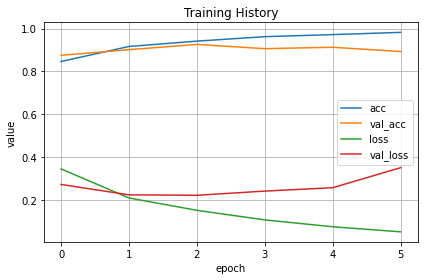

In [173]:
plot_history()

# Demonstrasi Prediksi

In [174]:
def predict(unseen_image = []):
    test_data = batchData(unseen_image,for_test=True)
    prediction = model.predict(test_data)

    for image,pred in zip(unseen_image,prediction):
        fig,axes = plt.subplots(nrows=1,ncols=2)
        axes[0].imshow(processImage(image))
        axes[0].axis(False)
        axes[0].set_title('Actual Image')

        axes[1].bar([0,1],pred)
        axes[1].set_xticks([0,1])
        axes[1].set_xticklabels(['with_mask','without_mask'])
        axes[1].set_title('Prediction Probability')
        plt.savefig(f'output/prediction_test_{image.split("/")[-1].split(".")[0]}.jpg')
        plt.show()

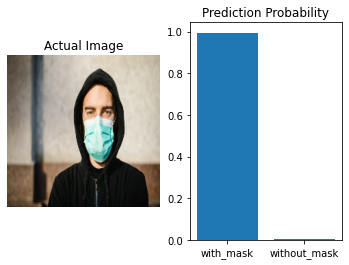

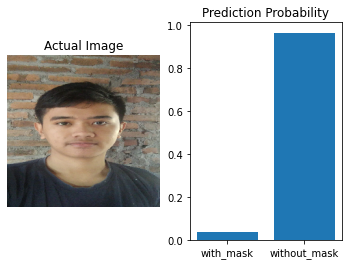

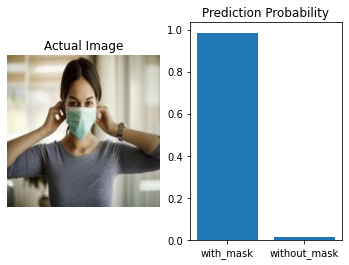

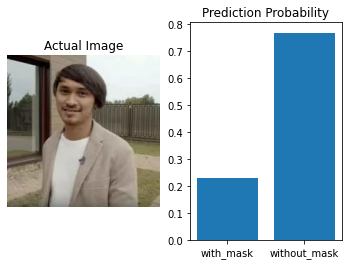

In [175]:
predict(list(map(lambda x : f'test/{x}', os.listdir('test'))))